In [1]:
%run local_imports.ipynb

In [2]:
distscan_dir = '/media/sf_Data/Genomes/extras/dist_haps/'
!ls -lh {distscan_dir}* | head

-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.00009778.00730787.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.00730788.01243275.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.01243276.01622713.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.01622714.01833911.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.01833912.01989789.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.01989790.02108439.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.02108440.02239834.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.02239835.02412740.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 15:40 /media/sf_Data/Genomes/extras/dist_haps/3L.02412741.02586161.npy
-rwxrwx--- 1 root vboxsf 21M ott 29 1

In [3]:
phase2happath = '/media/sf_Data/Genomes/variation/ag1000g.phase2.ar1.haplotypes/'
calldata_hap_phase2= zarr.open(phase2happath)
calldata_hap_phase2.tree()

/
 ├── 3L
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (7897666,) |S1
 │       ├── POS (7897666,) int32
 │       └── REF (7897666,) |S1
 └── 3R
     ├── samples (1164,) |S8
     └── variants
         ├── ALT (10752701,) |S1
         ├── POS (10752701,) int32
         └── REF (10752701,) |S1

In [4]:
tbl_samples = pd.read_csv("/media/sf_Data/Genomes/meta/samples.meta.txt", sep = "\t")
tbl_samples.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


------------------------------

# Funtion section for plotting

In [5]:
def open_dscan(chrom):

    # find the underlying matrix file names, we need these to get window boundaries
    dfns = sorted(glob.glob(os.path.join(distscan_dir, chrom + '*.npy')))
    bnms = [os.path.basename(f) for f in dfns]
    windows = np.array([[int(b.split('.')[1]), int(b.split('.')[2])] for b in bnms])
    n_windows = len(windows)
    log(n_windows, 'windows')

    # compile into a single array
    dscan_rootdir = os.path.join(distscan_dir, '%s.bcolz' % chrom)
    if not os.path.exists(dscan_rootdir):
        log('loading', dscan_rootdir)

        # load up the first matrix to determine shape
        d = np.load(dfns[0])
        n_pairs = d.shape[0]
        
        log(n_pairs, 'pairs')

        # setup bcolz array
        dscan = bcolz.carray(np.empty((0, n_pairs), dtype='f4'), 
                             cparams=bcolz.cparams(cname='zlib', clevel=1),
                             rootdir=dscan_rootdir,
                             mode='w',
                             expectedlen=n_windows)

        # load one row at a time
        for i, dfn in enumerate(dfns):
            if i > 0 and i % 20 == 0:
                log(i, dfn)
            dscan.append(np.load(dfn, mmap_mode='r'))
            dscan.flush()
        
    # open/re-open in read-only mode
    dscan = bcolz.carray(rootdir=dscan_rootdir, mode='r')

    return windows, dscan

In [6]:
def sample_to_haplotype_indices(sidx):
    return list(itertools.chain(*[[ix*2, ix*2+1] for ix in sidx])) 

In [7]:
def extract_2pop_dscan(chrom, pop1, pop2):

    callset = zarr.group(phase2happath)
    samples = [str(s, 'ascii') for s in callset[chrom]['samples'][:]]
    n_samples = len(samples)
    n_haplotypes = 2 * n_samples
    
    # load dscan
    windows, dscan = open_dscan(chrom)

    # locate sample indices
    pop1_sample_indices=tbl_samples.population[tbl_samples.population == pop1].index.tolist()
    pop2_sample_indices=tbl_samples.population[tbl_samples.population == pop2].index.tolist()

    # locate haplotype indices
    pop1_haplotype_indices = sample_to_haplotype_indices(pop1_sample_indices)
    pop2_haplotype_indices = sample_to_haplotype_indices(pop2_sample_indices)
    
    # locate indices of pairwise comparisons within and between populations

    db_ix = allel.condensed_coords_between(pop1_haplotype_indices, pop2_haplotype_indices, n_haplotypes)
    
    # extract pairwise distances

    db = allel.chunked.core.take(dscan, db_ix, axis=1)[:]
    
   
    return windows, db


In [23]:
def extract_2pop_dscan(chrom, pop1, pop2):

    callset = zarr.group(phase2happath)
    samples = [str(s, 'ascii') for s in callset[chrom]['samples'][:]]
    n_samples = len(samples)
    n_haplotypes = 2 * n_samples
    
    # load dscan
    windows, dscan = open_dscan(chrom)

    # locate sample indices
    pop1_sample_indices=tbl_samples.population[tbl_samples.population == pop1].index.tolist()
    pop2_sample_indices=tbl_samples.population[tbl_samples.population == pop2].index.tolist()

    # locate haplotype indices
    pop1_haplotype_indices = sample_to_haplotype_indices(pop1_sample_indices)
    pop2_haplotype_indices = sample_to_haplotype_indices(pop2_sample_indices)
    
    # locate indices of pairwise comparisons within and between populations
    dw1_ix = allel.condensed_coords_within(pop1_haplotype_indices, n_haplotypes)
    dw2_ix = allel.condensed_coords_within(pop2_haplotype_indices, n_haplotypes)
    db_ix = allel.condensed_coords_between(pop1_haplotype_indices, pop2_haplotype_indices, n_haplotypes)
    
    # extract pairwise distances
    dw1 = allel.chunked.core.take(dscan, dw1_ix, axis=1)[:]
    dw2 = allel.chunked.core.take(dscan, dw2_ix, axis=1)[:]
    db = allel.chunked.core.take(dscan, db_ix, axis=1)[:]
    
   
    return windows, dw1, dw2, db


In [12]:
def run_2pop_analysis(pop1, pop2):
    for chrom in autosomes:
        fig = plt.figure(figsize=(13, 11))
        windows, dw1, dw2, db = extract_2pop_dscan(chrom, pop1, pop2)
        
        ax = fig.add_subplot(4, 1, 1)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw1, title='%s, %s' % (pop1, chrom), color=palette[0], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 2)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw2, title='%s, %s' % (pop2, chrom), color=palette[1], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 3)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), color=palette[2], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$d_{XY}$', rotation=0, ha='right', va='center')

        ax = fig.add_subplot(4, 1, 4)
        sns.despine(ax=ax, offset=5)
        plot_gmin(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), ax=ax)
        ax.set_xlabel('position (bp)')
        
        fig.tight_layout()
        plt.show()

In [8]:
def closest_argmin(A, B):
    L = B.size
    sidx_B = B.argsort()
    sorted_B = B[sidx_B]
    sorted_idx = np.searchsorted(sorted_B, A)
    sorted_idx[sorted_idx==L] = L-1
    mask = (sorted_idx > 0) & \
    ((np.abs(A - sorted_B[sorted_idx-1]) < np.abs(A - sorted_B[sorted_idx])) )
    return sidx_B[sorted_idx-mask]

-----------------------------------------

# Chromosome 3L

In [9]:
tbl_pos_3L = pd.read_csv('/home/randomx/Scaricati/tbl_pos_3L.tab', index_col= 0)
tbl_pos_3L

,chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,center_gene
0,3L,AGAP010317,31,4,21.459164,28.0,1.0,0.672572,414140
1,3L,AGAP010310,118,3,2.876340,NaN,NaN,0.000000,74374
2,3L,AGAP010742,1949,1,1.366328,NaN,NaN,0.000000,9360663


In [10]:
windows_3L, dxy_3L = extract_2pop_dscan('3L', 'BFcol', 'BFgam')

250 windows


In [13]:
windows_array = windows_3L.flatten()

In [14]:
pos_genes = np.asarray(tbl_pos_3L["center_gene"])
pos_genes

array([ 414140,   74374, 9360663])

In [15]:
genes_array = np.asarray(tbl_pos_3L["gene"])
genes_array

array(['AGAP010317', 'AGAP010310', 'AGAP010742'], dtype=object)

In [16]:
closest_argmin(pos_genes, windows_array)/2

array([ 0.5,  0. , 46. ])

In [17]:
genes_array

array(['AGAP010317', 'AGAP010310', 'AGAP010742'], dtype=object)

In [25]:
def plot_dist_scan(windows, d, ylim=(0, 0.016), title=None, color=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(12, 4))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # median
    y = np.median(d, axis=1)
    ax.plot(x, y, color=color, lw=1)
    
    # interquartile range
    y1 = np.percentile(d, 25, axis=1)
    y2 = np.percentile(d, 75, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.6)
    
    # 5-95 range
    y1 = np.percentile(d, 5, axis=1)
    y2 = np.percentile(d, 95, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.4)
    
    # total range
    y1 = d.min(axis=1)
    y2 = d.max(axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.2)
    
    #genes_location
    
    ax.annotate('AGAP010313 \n AGAP010317', xy=(x[1],y[1]),xytext=(0.1, 0.07), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))

    
    ax.annotate('AGAP010742', xy=(x[46],y[46]),xytext=(0.10, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
            
    # tidy up
    ax.set_ylim(*ylim)
    
    # legend
    handles = list()
    # median
    l = plt.Line2D([], [], color=color, linestyle='-', linewidth=2, label='median')
    handles.append(l)
    # percentiles
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.6, lw=0, label='25-75th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.4, lw=0, label='5-95th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.2, lw=0, label='min-max')
    handles.append(r)
    ax.legend(handles=handles, bbox_to_anchor=[1, 1], loc='upper left')    
    ax.set_yticks([0, .005, .01, .015])
    ax.set_xlim(0, windows[-1, -1])
    

In [26]:
def plot_gmin(windows, d, title=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(12, 4))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # Gmin
    y = d.min(axis=1) / d.mean(axis=1)
    ax.plot(x, y, color='k', lw=1, linestyle='-')
        
    # tidy up
    ax.annotate('AGAP010313 \n AGAP010317', xy=(x[1],y[1]),xytext=(0.07, 0.15), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))

    
    ax.annotate('AGAP010742', xy=(x[46],y[46]),xytext=(0.10, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.set_ylabel(r'$G_{min}$', rotation=0, ha='right', va='center')
    ax.set_xlim(0, windows[-1, -1])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

In [29]:
autosomes = ['3L']

250 windows


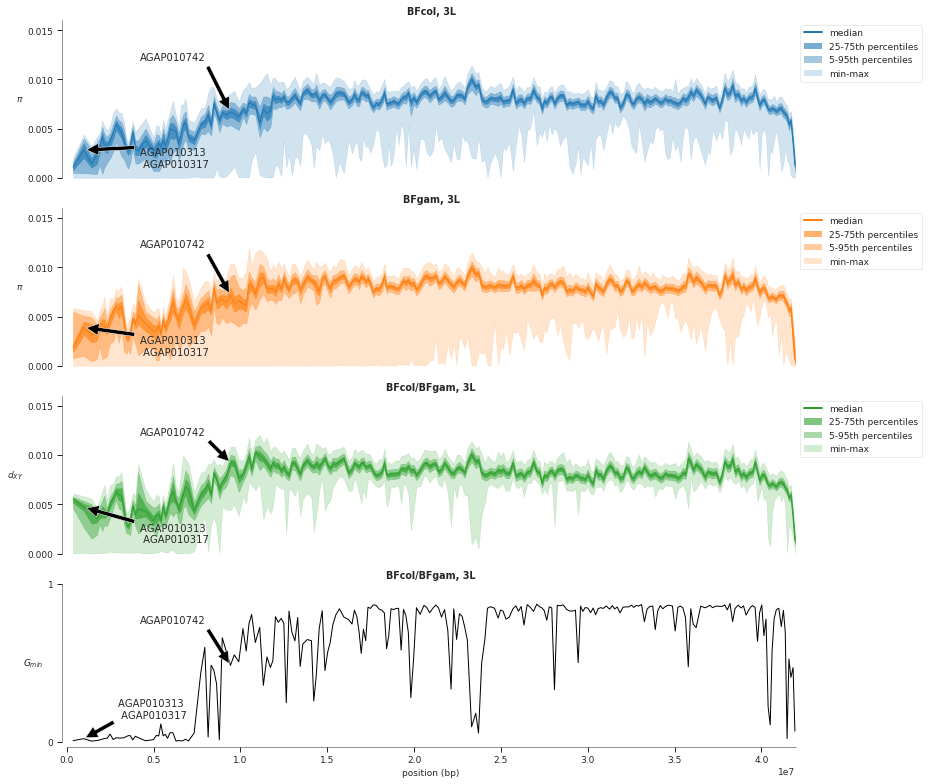

In [30]:
run_2pop_analysis('BFcol', 'BFgam')

----------------------------------

# Chromosome 3R
A lot of genes..!!!

In [33]:
tbl_pos_3R = pd.read_csv('/home/randomx/Scaricati/tbl_pos_3R.tab', index_col= 0)
tbl_pos_3R

,chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,center_gene
0,3R,AGAP010302,42,4,16.176921,51.0,1.0,0.338726,52853378
1,3R,AGAP010304,56,4,12.244166,NaN,NaN,0.000000,52973950
2,3R,AGAP009934,44,2,3.103201,50.0,1.0,0.347698,45615025
3,3R,AGAP010303,59,2,2.293980,NaN,NaN,0.000000,52920804
4,3R,AGAP010293,69,2,1.939209,81.0,1.0,0.158699,52356782
5,3R,AGAP010044,1977,1,1.390037,NaN,NaN,0.000000,48178590
6,3R,AGAP010298,14,1,1.307186,NaN,NaN,0.000000,52656475


In [34]:
windows_3R, dxy_3R = extract_2pop_dscan('3R', 'BFcol', 'BFgam')

325 windows


In [35]:
windows_array = windows_3R.flatten()
len(windows_array)

650

In [36]:
pos_genes = np.asarray(tbl_pos_3R["center_gene"])
pos_genes

array([52853378, 52973950, 45615025, 52920804, 52356782, 48178590,
       52656475])

In [37]:
closest_argmin(pos_genes, windows_array)/2

array([324. , 324. , 285.5, 324. , 323. , 300. , 323.5])

In [38]:
genes_array = np.asarray(tbl_pos_3R["gene"])
genes_array

array(['AGAP010302', 'AGAP010304', 'AGAP009934', 'AGAP010303',
       'AGAP010293', 'AGAP010044', 'AGAP010298'], dtype=object)

In [53]:
def plot_dist_scan(windows, d, ylim=(0, 0.016), title=None, color=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(12, 4))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # median
    y = np.median(d, axis=1)
    ax.plot(x, y, color=color, lw=1)
    
    # interquartile range
    y1 = np.percentile(d, 25, axis=1)
    y2 = np.percentile(d, 75, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.6)
    
    # 5-95 range
    y1 = np.percentile(d, 5, axis=1)
    y2 = np.percentile(d, 95, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.4)
    
    # total range
    y1 = d.min(axis=1)
    y2 = d.max(axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.2)
    
    #genes_location
    ax.annotate('AGAP009934', xy=(x[286],y[286]),xytext=(0.8, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('AGAP010293', xy=(x[323],y[323]),xytext=(0.85, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('AGAP010044', xy=(x[300],y[300]),xytext=(0.83, 0.09), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
        
    ax.annotate('AGAP010298 \n AGAP010302 \n AGAP010303 \n AGAP010304', xy=(x[324],y[324]),xytext=(1.05, 0.01), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))

            
    # tidy up
    ax.set_ylim(*ylim)
    
    # legend
    handles = list()
    # median
    l = plt.Line2D([], [], color=color, linestyle='-', linewidth=2, label='median')
    handles.append(l)
    # percentiles
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.6, lw=0, label='25-75th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.4, lw=0, label='5-95th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.2, lw=0, label='min-max')
    handles.append(r)
    ax.legend(handles=handles, bbox_to_anchor=[1, 1], loc='upper left')    
    ax.set_yticks([0, .005, .01, .015])
    ax.set_xlim(0, windows[-1, -1])
    

In [54]:
def plot_gmin(windows, d, title=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(12, 4))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # Gmin
    y = d.min(axis=1) / d.mean(axis=1)
    ax.plot(x, y, color='k', lw=1, linestyle='-')
        
    # tidy up
    ax.annotate('AGAP009934', xy=(x[286],y[286]),xytext=(0.75, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('AGAP010293', xy=(x[323],y[323]),xytext=(1.05, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('AGAP010044', xy=(x[300],y[300]),xytext=(0.85, 1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
        
    ax.annotate('AGAP010298 \n AGAP010302 \n AGAP010303 \n AGAP010304', xy=(x[324],y[324]),xytext=(1.05, 0.01), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.set_ylabel(r'$G_{min}$', rotation=0, ha='right', va='center')
    ax.set_xlim(0, windows[-1, -1])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

In [55]:
autosomes = ['3R']

325 windows


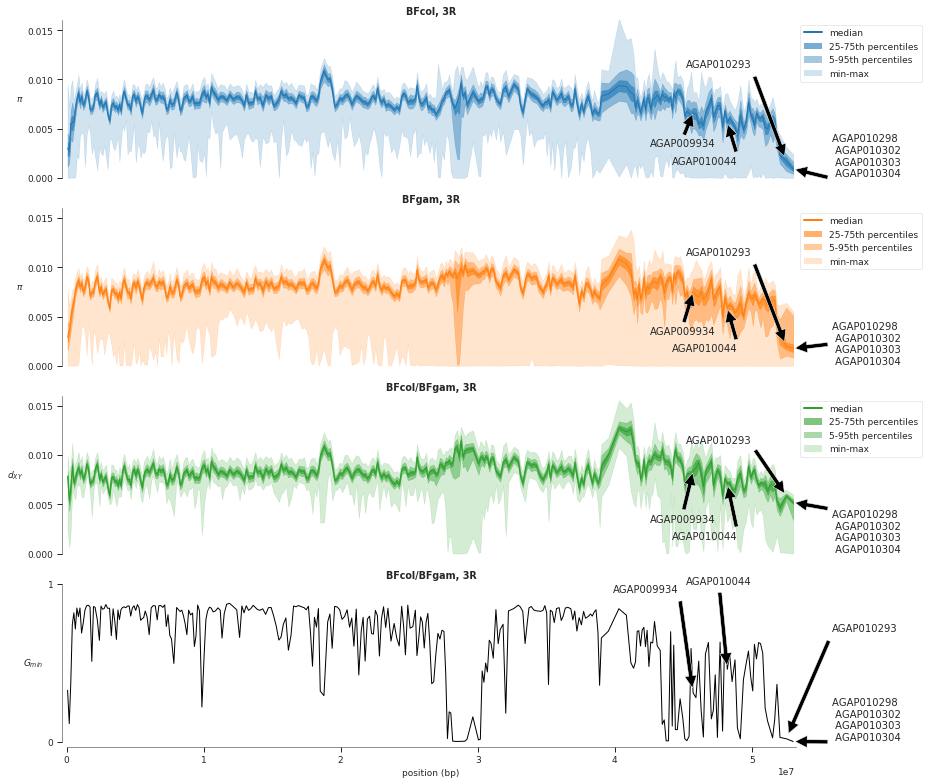

In [56]:
run_2pop_analysis('BFcol', 'BFgam')

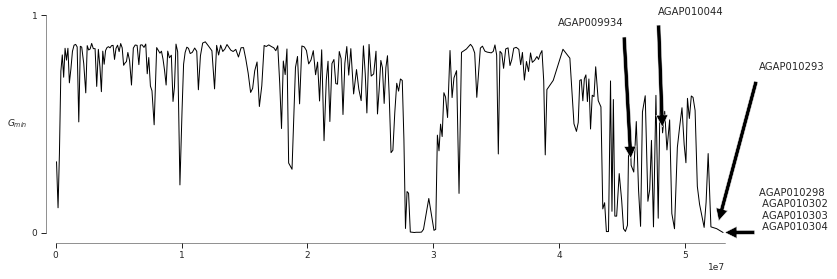

In [69]:
plot_gmin(windows_3R, dxy_3R)

--------------------------------

In [ ]:
# Gmin investigation

In [11]:
windows_3L, dxy_3L = extract_2pop_dscan('3L', 'BFcol', 'BFgam')

250 windows


In [36]:
x = np.array(windows_3L[125:150]).mean(axis=1)
x

array([ 22764552.5,  22913596. ,  23066482.5,  23310432.5,  23552163.5,
        23709818. ,  23891403. ,  24076107.5,  24225915.5,  24395215. ,
        24631165. ,  24842920.5,  24979401. ,  25125656.5,  25290582. ,
        25485257.5,  25688549. ,  25859812. ,  26012921. ,  26169218.5,
        26327903. ,  26511558. ,  26688969.5,  26873705. ,  27066083.5])

In [37]:
def plot_gmin(windows, d, title=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(8, 1.5))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows_3L[125:150]).mean(axis=1)

    # Gmin
    y = d[125:150].min(axis=1) / d[125:150].mean(axis=1)
    ax.plot(x, y, color='k', lw=1, linestyle='-')
        
    # tidy up
    ax.set_ylabel(r'$G_{min}$', rotation=0, ha='right', va='center')
    #ax.set_xlim(0, windows[-1, -1])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

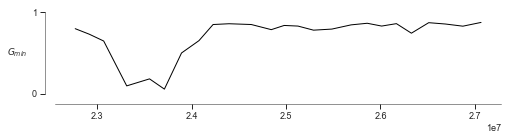

In [38]:
plot_gmin(windows_3L, dxy_3L, title=None, ax=None)

---------------------------------------

In [5]:
populations = 'BFcol', 'BFgam'

In [6]:
pop_colours = {
    'BFcol': '#FF0000',
    'BFgam': '#1E90FF',
}

In [13]:
chrom = '3L'
start = 10359660
stop = 10389853
pi_fn = '/mnt/70D89269D8922CFA/Genomes/extras/pi.windows_eqaccess.h5'
pi = h5py.File(pi_fn, 'r')

In [14]:
tbl_pos_3R = pd.read_csv('/home/randomx/Scaricati/tbl_pos_3R(1).tab', index_col= 0)
tbl_pos_3R

,chrom,gene,hka_score,homogeneity_score,fst_score,start,end
0,3R,AGAP010308,2.902998,0.181750,0.721132,53091293,53094028
1,3R,AGAP010302,16.176921,0.539350,0.696769,52851999,52854757
2,3R,AGAP010297,0.268726,0.297718,0.655567,52614350,52617318
3,3R,AGAP010295,0.242328,0.387374,0.729047,52457332,52554377
4,3R,AGAP010294,1.400733,0.016670,0.724723,52418651,52422892
5,3R,AGAP010293,1.939209,0.045922,0.828777,52354660,52358904
6,3R,AGAP010290,1.805550,0.036897,0.622626,52237449,52248062
7,3R,AGAP010289,0.904142,0.067339,0.732943,52212077,52213576
8,3R,AGAP010286,0.514623,0.106362,0.643305,52067738,52115209
9,3R,AGAP010184,3.123131,0.102711,0.240180,49983895,50074391


In [15]:
tbl_pos_3L = pd.read_csv('/home/randomx/Scaricati/tbl_pos_3L(1).tab', index_col= 0)
tbl_pos_3L

,chrom,gene,hka_score,homogeneity_score,fst_score,start,end
0,3L,AGAP010788,0.468704,0.041860,0.248323,10359660,10389853
1,3L,AGAP010781,0.053944,0.215992,0.570446,10277400,10283541
2,3L,AGAP010317,21.459164,0.324443,0.843193,413217,415064
3,3L,AGAP010313,9.849562,0.480380,0.751059,293919,305802


In [48]:
def plot_pi(chrom, start, stop, winsize):
    
    winsize = winsize
    pia = pi[winsize][chrom]['BFcol']['windows'][:]
    geoff = (pia[:,0] > start) & (pia[:,1] < stop)
    pia.shape, geoff.shape
    
    diversity = dict()

    for pop in populations:
        pi_all = pi[winsize][chrom][pop]['pi'][:]
        diversity[pop] = pi_all.compress(geoff, axis=0)

    # Create a figure instance
    fig, ax = plt.subplots(figsize=(10,3))

    # Create an axes instance
    sns.despine(ax=ax, offset=5)
    # Create the boxplot
    lw=0.7
    bp = ax.boxplot(x=[diversity[pop] for pop in populations],
            labels=populations,  patch_artist=True, 
            medianprops={"color":"k", "linewidth":lw},
            whiskerprops={"color":"k"}, 
            capprops={"color":"k"},
            showfliers=False,
            flierprops={"c":"k", "markersize":0.7})

    for p in populations:
        plt.xticks(rotation='vertical')

    plt.ylabel(r'$\pi$', rotation = 0, fontsize=12)
    plt.xlabel('population', va='top')
    plt.ylim(0,0.021)

    for patch, color in zip(bp['boxes'], [pop_colours[pop] for pop in populations]):
        patch.set_color('k')
        patch.set_facecolor(color)
        patch.set_linewidth(lw)


    handles = [mpl.patches.Patch(color=pop_colours[pop]) for pop in populations]
    plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(-0.06, 1.08), ncol=5);
#fn = '../artwork/pi.jpeg'
#fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

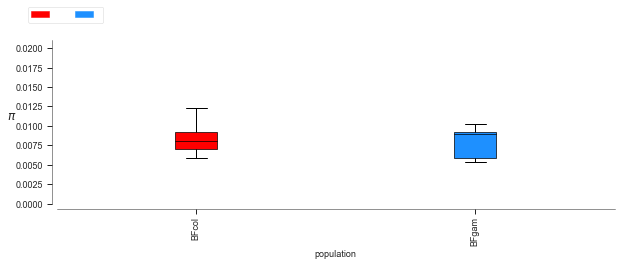

In [49]:
plot_pi('3L', 10359660,10389853, '2000')

---------------------

In [50]:
start_3L = tbl_pos_3L['start']

In [51]:
end_3L = tbl_pos_3L['end']

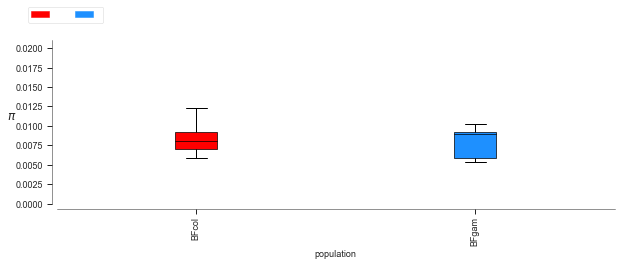

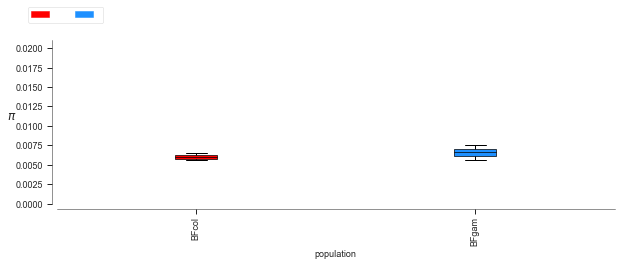

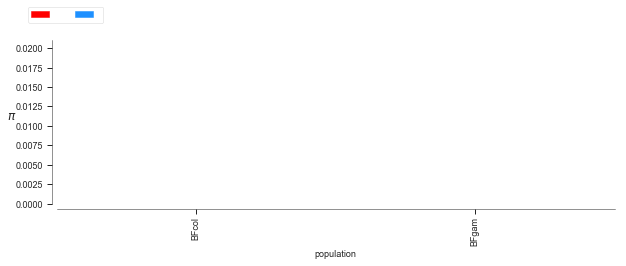

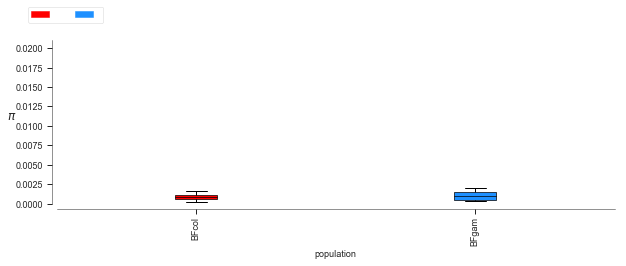

In [52]:
for i in range(len(start_3L)):
    plot_pi('3L', start_3L[i], end_3L[i], '2000')

------------------------------

In [53]:
start_3R = tbl_pos_3R['start']

In [272]:
end_3R = tbl_pos_3R['end']

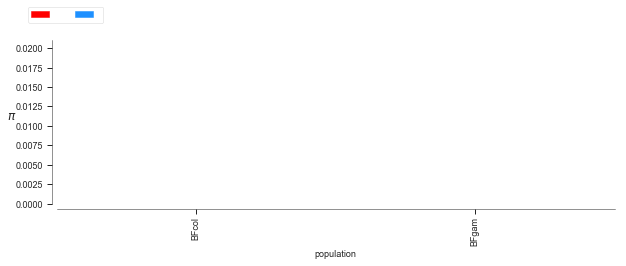

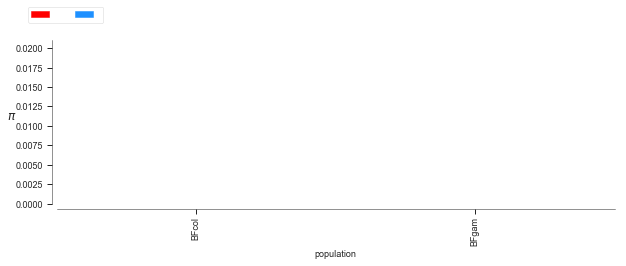

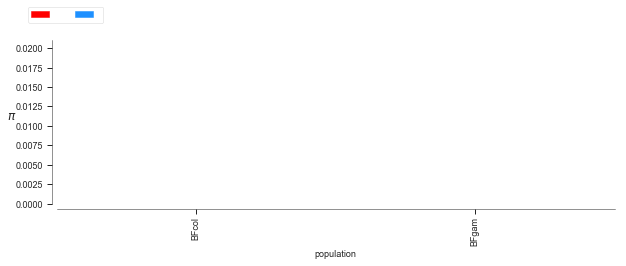

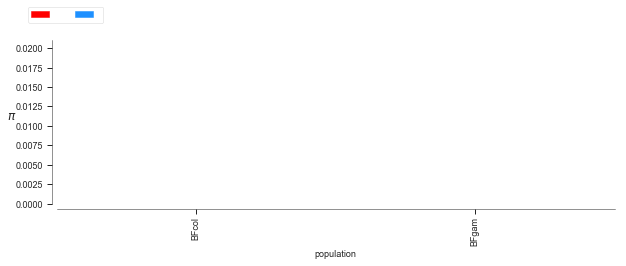

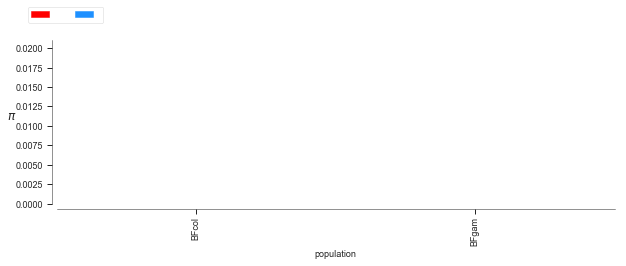

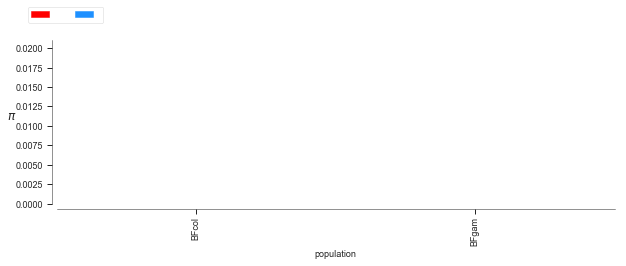

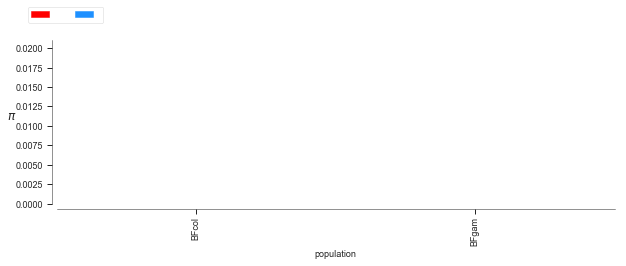

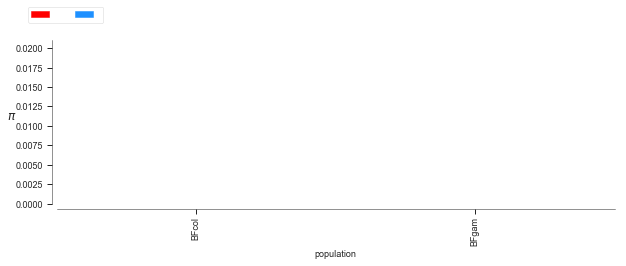

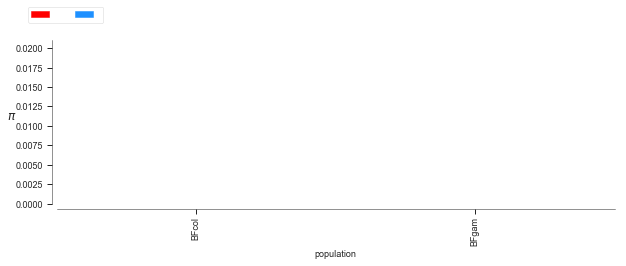

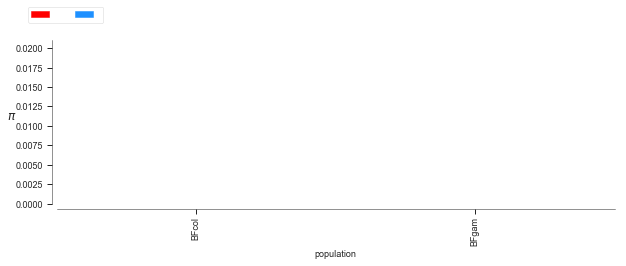

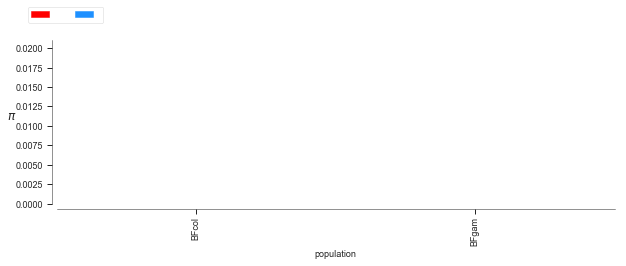

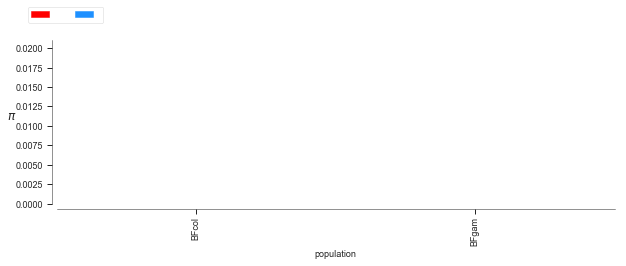

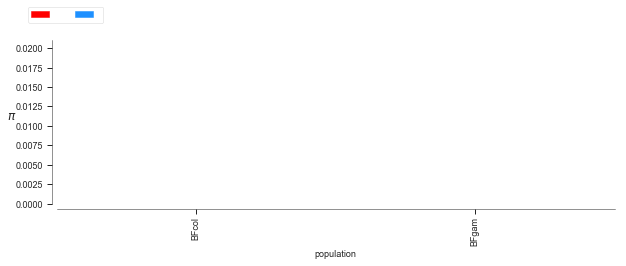

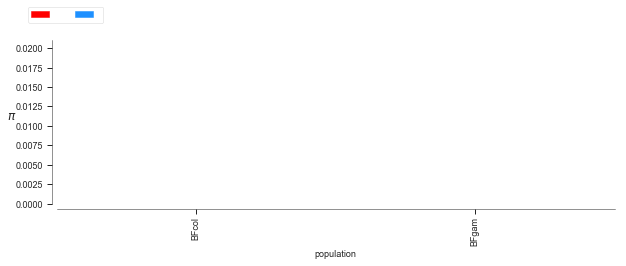

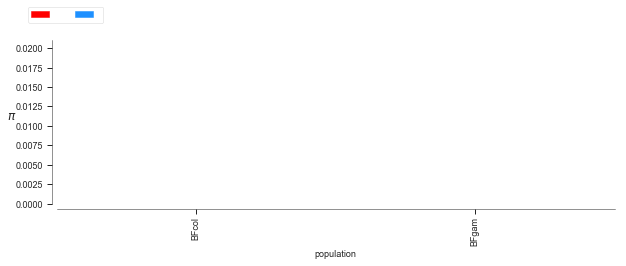

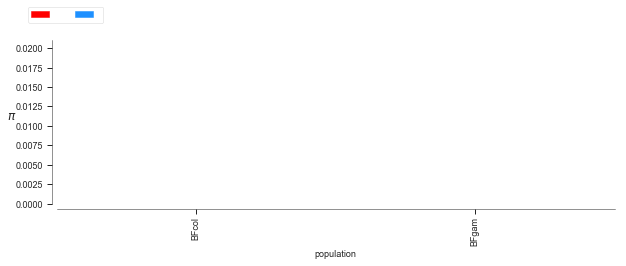

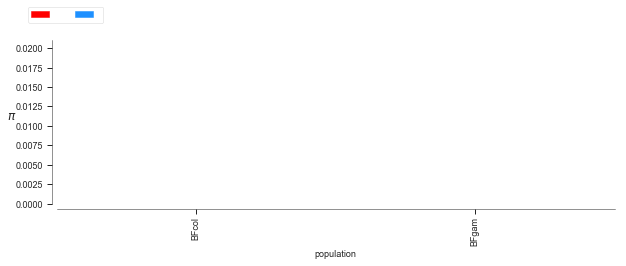

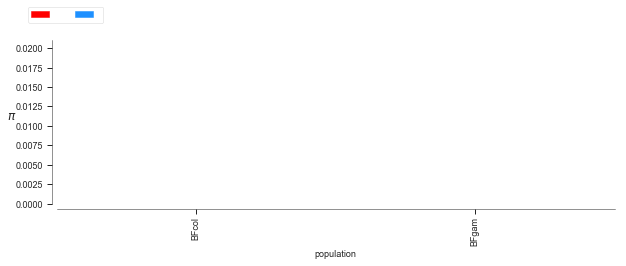

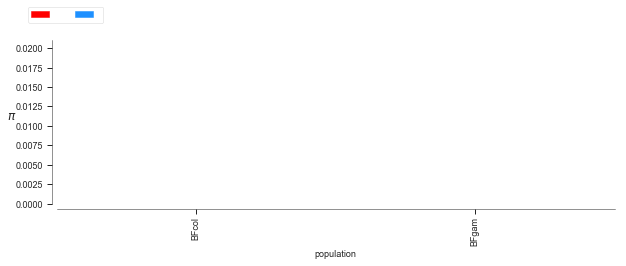

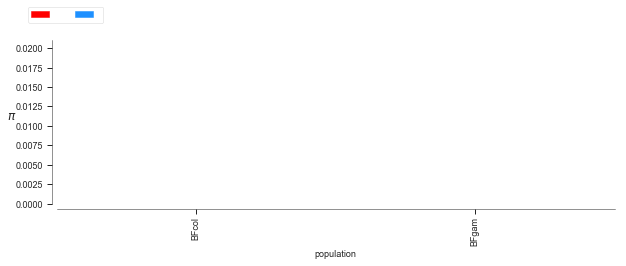

In [55]:
for i in range(len(end_3R)):
    plot_pi('3R', end_3R[i], end_3R[i], '2000')

---------------------------------

In [203]:
callset = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.haplotypes/')
callset.tree()

/
 ├── 3L
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (7897666,) |S1
 │       ├── POS (7897666,) int32
 │       └── REF (7897666,) |S1
 └── 3R
     ├── samples (1164,) |S8
     └── variants
         ├── ALT (10752701,) |S1
         ├── POS (10752701,) int32
         └── REF (10752701,) |S1

In [251]:
accessibility = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/accessibility.h5')

In [204]:
pos_3L = allel.SortedIndex(callset['3L']['variants']['POS'][:])
pos_3R = allel.SortedIndex(callset['3R']['variants']['POS'][:])

In [205]:
pop_select = tbl_samples.population.isin({'BFcol', 'BFgam'}).values
pop_subset = tbl_samples[pop_select]

In [206]:
haplotypes_3L = allel.GenotypeChunkedArray(callset['3L']["calldata/GT"])

In [207]:
haplotypes_3R = allel.GenotypeChunkedArray(callset['3R']["calldata/GT"])

In [208]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops_3L = haplotypes_3L.count_alleles_subpops(grp_indices)
ac_subpops_3R = haplotypes_3R.count_alleles_subpops(grp_indices)

In [261]:
bfcol_3L = pd.DataFrame([])
for i in range(len(start_3L)):
    x=[]
    x.append(allel.sequence_diversity(pos_3L, ac_subpops['BFcol'], start_3L[i], end_3L[i]))
    bfcol_3L = bfcol_3L.append(x)

In [262]:
bfgam_3L = pd.DataFrame([])
for i in range(len(start_3L)):
    x=[]
    x.append(allel.sequence_diversity(pos_3L, ac_subpops['BFgam'], start_3L[i], end_3L[i]))
    bfgam_3L = bfgam_3L.append(x)

In [263]:
bfcol_3R = pd.DataFrame([])
for i in range(len(start_3R)):
    x=[]
    x.append(allel.sequence_diversity(pos_3R, ac_subpops['BFcol'], start_3R[i], end_3R[i]))
    bfcol_3R = bfcol_3R.append(x)

In [265]:
bfgam_3R = pd.DataFrame([])
for i in range(len(start_3R)):
    x=[]
    x.append(allel.sequence_diversity(pos_3R, ac_subpops['BFgam'], start_3R[i], end_3R[i]))
    bfgam_3R = bfgam_3R.append(x)

In [266]:
def bar_plot(score1,score2, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    

    # set width of bar
    barWidth = 0.25

    # set height of bar
    score_bf = score1
    score_gh = score2

    # Set position of bar on X axis
    r1 = np.arange(len(score1))
    r3 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, score_bf, color='#FF0000', width=barWidth, edgecolor='white', label='An.coluzzii')
    plt.bar(r3, score_gh, color='#1E90FF', width=barWidth, edgecolor='white', label='An.gambiae')

    # Add xticks on the middle of the group bars
    plt.xlabel('Genes', fontweight='bold')
    plt.xticks([r for r in range(len(score1))], ['AGAP010788', 'AGAP010781', 'AGAP010317', 'AGAP010313'], rotation=45)
    plt.ylabel('pi', fontweight='bold')

    sns.despine()
    ax.set_title(title)
    # Create legend & Show graphic
    plt.legend()
    plt.show()

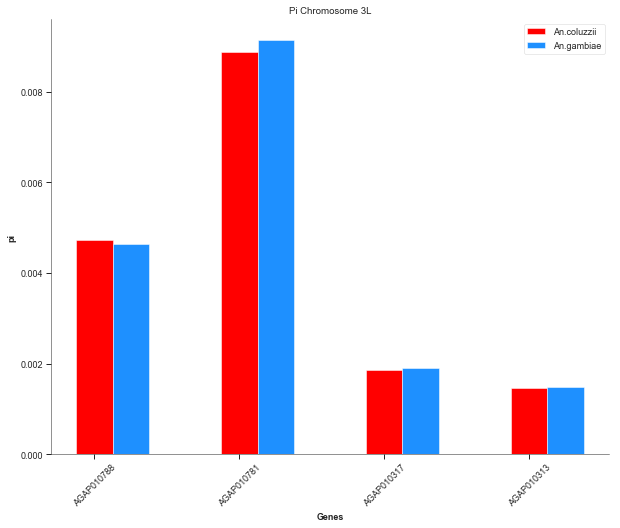

In [267]:
bar_plot(bfcol_3L[0],bfgam_3L[0],'Pi Chromosome 3L')

In [268]:
def bar_plot(score1,score2, title):
    fig, ax = plt.subplots(figsize=(15, 8))
    

    # set width of bar
    barWidth = 0.25

    # set height of bar
    score_bf = score1
    score_gh = score2

    # Set position of bar on X axis
    r1 = np.arange(len(score1))
    r3 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, score_bf, color='#FF0000', width=barWidth, edgecolor='white', label='An.coluzzii')
    plt.bar(r3, score_gh, color='#1E90FF', width=barWidth, edgecolor='white', label='An.gambiae')

    # Add xticks on the middle of the group bars
    plt.xlabel('Genes', fontweight='bold')
    plt.xticks([r for r in range(len(score1))], ['AGAP010308', 'AGAP010302', 'AGAP010297', 'AGAP010295',
       'AGAP010294', 'AGAP010293', 'AGAP010290', 'AGAP010289',
       'AGAP010286', 'AGAP010184', 'AGAP010147', 'AGAP009934',
       'AGAP009805', 'AGAP007762', 'AGAP007761', 'AGAP007737',
       'AGAP007736', 'AGAP007734', 'AGAP007732', 'AGAP007731'], rotation=45)
    plt.ylabel('pi', fontweight='bold')

    sns.despine()
    ax.set_title(title)
    # Create legend & Show graphic
    plt.legend()
    plt.show()

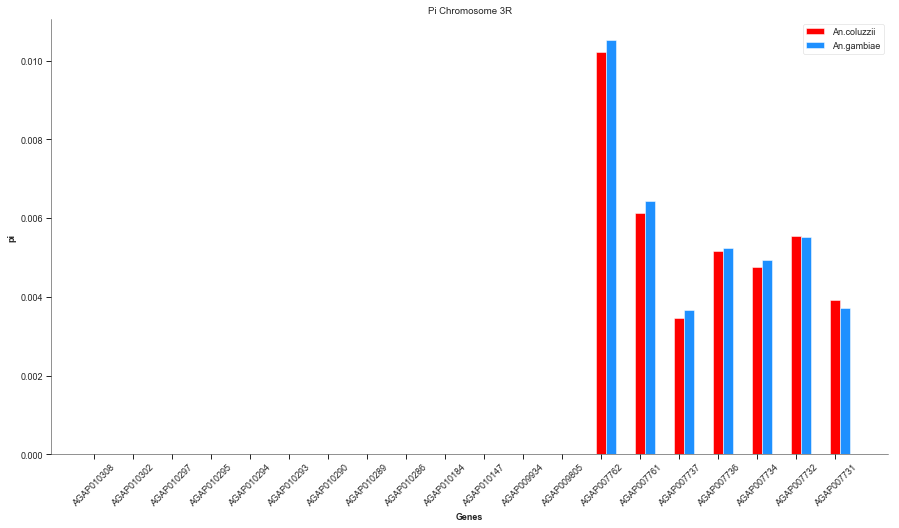

In [269]:
bar_plot(bfcol_3R[0],bfgam_3R[0],'Pi Chromosome 3R')

In [270]:
bfcol_3R

,0
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000


In [271]:
bfgam_3R

,0
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
0,0.000000
